In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima_process import ArmaProcess

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt


In [2]:
np.random.seed(42)

ar = np.array([1, -0.8])
ma = np.array([1])
arma = ArmaProcess(ar, ma)

n = 1500
feature1 = arma.generate_sample(nsample=n)
feature2 = np.sin(np.linspace(0, 30, n)) + np.random.normal(0, 0.1, n)
feature3 = np.random.normal(0, 1, n).cumsum()

target = (
    0.4 * feature1 +
    0.3 * feature2 +
    0.2 * feature3 +
    np.random.normal(0, 0.3, n)
)

df = pd.DataFrame({
    "feature1": feature1,
    "feature2": feature2,
    "feature3": feature3,
    "target": target
})


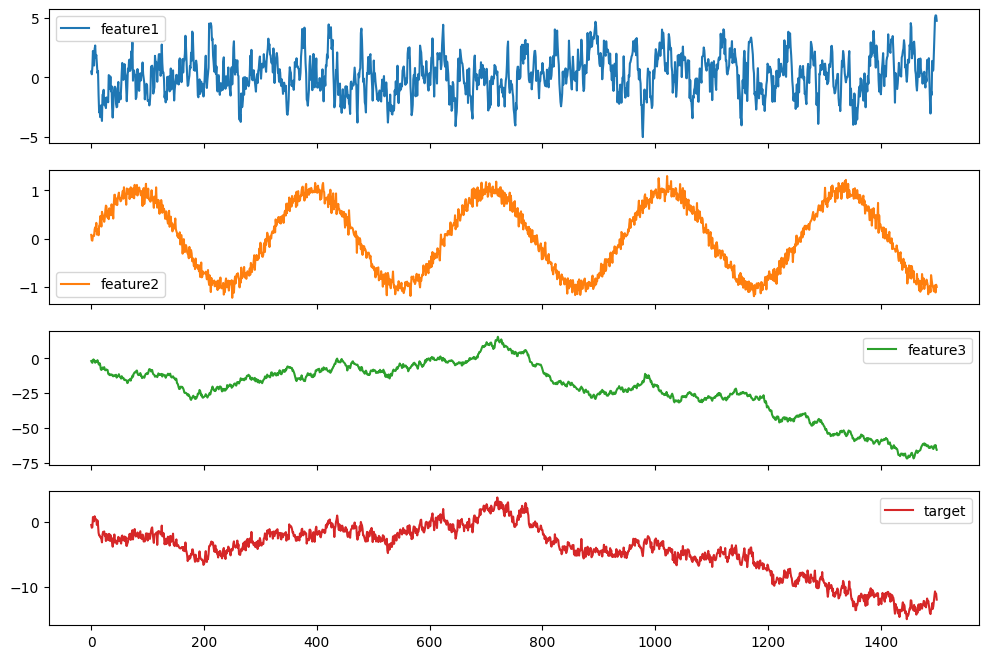

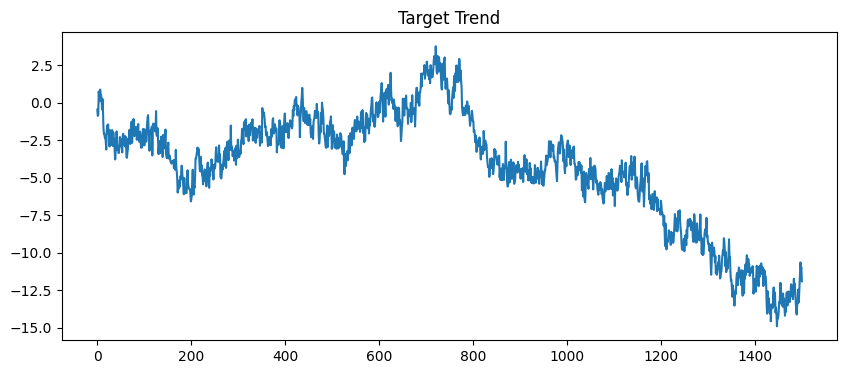

In [3]:
df.plot(subplots=True, figsize=(12, 8))
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["target"])
plt.title("Target Trend")
plt.show()


In [4]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled, columns=df.columns)

train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))

train = scaled_df[:train_size]
val = scaled_df[train_size:train_size + val_size]
test = scaled_df[train_size + val_size:]


In [5]:
def make_windows(data, window=20):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data.iloc[i:i + window].values)
        y.append(data.iloc[i + window]["target"])
    return np.array(X), np.array(y)

window = 20
X_train, y_train = make_windows(train, window)
X_val, y_val = make_windows(val, window)
X_test, y_test = make_windows(test, window)


In [6]:
y_pred_baseline = test["target"].shift(1).iloc[window:].values
y_true_baseline = test["target"].iloc[window:].values

rmse_base = np.sqrt(mean_squared_error(y_true_baseline, y_pred_baseline))
mae_base = mean_absolute_error(y_true_baseline, y_pred_baseline)

print("Baseline RMSE:", rmse_base)
print("Baseline MAE:", mae_base)


Baseline RMSE: 0.17151641766217912
Baseline MAE: 0.14225553328639445


In [7]:
def lstm_builder(hp):
    model = Sequential()
    model.add(
        LSTM(
            hp.Int("units", min_value=32, max_value=128, step=32),
            input_shape=(window, scaled_df.shape[1])
        )
    )
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")
    return model

tuner_lstm = kt.RandomSearch(
    lstm_builder,
    objective="val_loss",
    max_trials=4,
    overwrite=True,
    directory="tuner_lstm"
)

tuner_lstm.search(X_train, y_train,
                  epochs=20,
                  validation_data=(X_val, y_val))

best_lstm = tuner_lstm.get_best_models(1)[0]

best_lstm.save("lstm_model.keras")  # FIXED saving error


Trial 4 Complete [00h 00m 34s]
val_loss: 0.1619226634502411

Best val_loss So Far: 0.0413236990571022
Total elapsed time: 00h 03m 10s


C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [8]:
def gru_builder(hp):
    model = Sequential()
    model.add(
        GRU(
            hp.Int("units", min_value=32, max_value=128, step=32),
            input_shape=(window, scaled_df.shape[1])
        )
    )
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")
    return model

tuner_gru = kt.RandomSearch(
    gru_builder,
    objective="val_loss",
    max_trials=4,
    overwrite=True,
    directory="tuner_gru"
)

tuner_gru.search(X_train, y_train,
                 epochs=20,
                 validation_data=(X_val, y_val))

best_gru = tuner_gru.get_best_models(1)[0]

best_gru.save("gru_model.keras")   # FIXED


Trial 4 Complete [00h 00m 34s]
val_loss: 0.024038041010499

Best val_loss So Far: 0.023630935698747635
Total elapsed time: 00h 02m 43s


In [9]:
y_pred_lstm = best_lstm.predict(X_test).flatten()
y_pred_gru = best_gru.predict(X_test).flatten()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


In [10]:
def eval_model(y_true, y_pred):
    return (
        np.sqrt(mean_squared_error(y_true, y_pred)),
        mean_absolute_error(y_true, y_pred)
    )

rmse_lstm, mae_lstm = eval_model(y_test, y_pred_lstm)
rmse_gru, mae_gru = eval_model(y_test, y_pred_gru)

results = pd.DataFrame({
    "Model": ["Baseline", "LSTM", "GRU"],
    "RMSE": [rmse_base, rmse_lstm, rmse_gru],
    "MAE": [mae_base, mae_lstm, mae_gru]
})

print(results)


      Model      RMSE       MAE
0  Baseline  0.171516  0.142256
1      LSTM  0.574928  0.532292
2       GRU  0.311444  0.271541


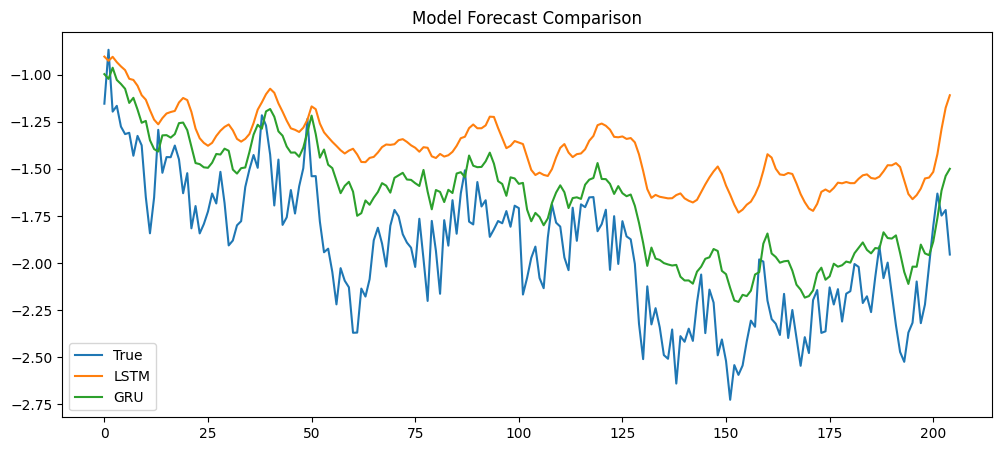

In [11]:
plt.figure(figsize=(12,5))
plt.plot(y_test, label="True")
plt.plot(y_pred_lstm, label="LSTM")
plt.plot(y_pred_gru, label="GRU")
plt.title("Model Forecast Comparison")
plt.legend()
plt.show()
